
Processing setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Found 28 users in setting 'vf_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
23 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 76.2% ±  2.8%	 16.2% ±  2.4%	 68.4% ±  6.2%	+0.087 ± 0.031
With Explanation         	 22.1% ±  2.7%	 49.6% ±  3.2%	 63.6% ±  3.5%	+0.212 ± 0.055
With Explanation + Quality	  6.2% ±  1.6%	 58.8% ±  3.2%	 62.7% ±  3.2%	+0.237 ± 0.061
76.2% ± 2.8%, 16.2% ± 2.4%, 68.4% ± 6.2%, 0.087 ± 0.031, 22.1% ± 2.7%, 49.6% ± 3.2%, 63.6% ± 3.5%, 0.212 ± 0.055, 6.2% ± 1.6%, 58.8% ± 3.2%, 62.7% ± 3.2%, 0.237 ± 0.061

Setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  22.1%		 +0.125 ± 0.052
Quality		   6.2%		 +0.025 ± 0.040

Setting: vf_numeric_llava1.5_with_image_q

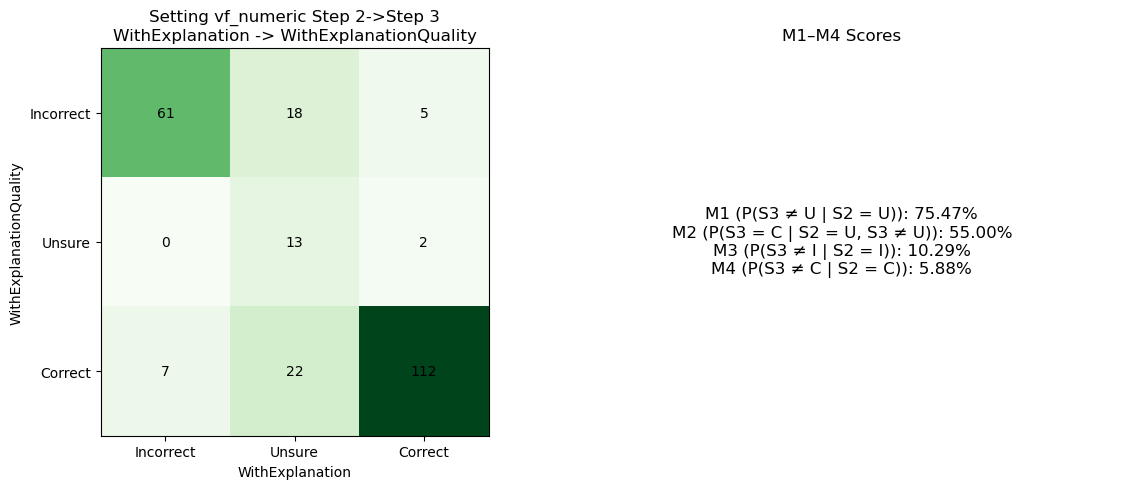


Processing setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_numeric_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
26 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 75.4% ±  2.7%	 16.9% ±  2.3%	 68.8% ±  5.8%	+0.092 ± 0.030
With Explanation         	 20.4% ±  2.5%	 49.6% ±  3.1%	 62.3% ±  3.4%	+0.196 ± 0.054
With Explanation + Quality	  7.3% ±  1.6%	 57.3% ±  3.1%	 61.8% ±  3.1%	+0.219 ± 0.058
75.4% ± 2.7%, 16.9% ± 2.3%, 68.8% ± 5.8%, 0.092 ± 0.030, 20.4% ± 2.5%, 49.6% ± 3.1%, 62.3% ± 3.4%, 0.196 ± 0.054, 7.3% ± 1.6%, 57.3% ± 3.1%, 61.8% ± 3.1%, 0.219 ± 0.058

Setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  20.4%		 +0.104 ± 0.048
Quality		   7.3%		 +0.023 ± 0.039

Setting: contr_numeric_llava1.5_

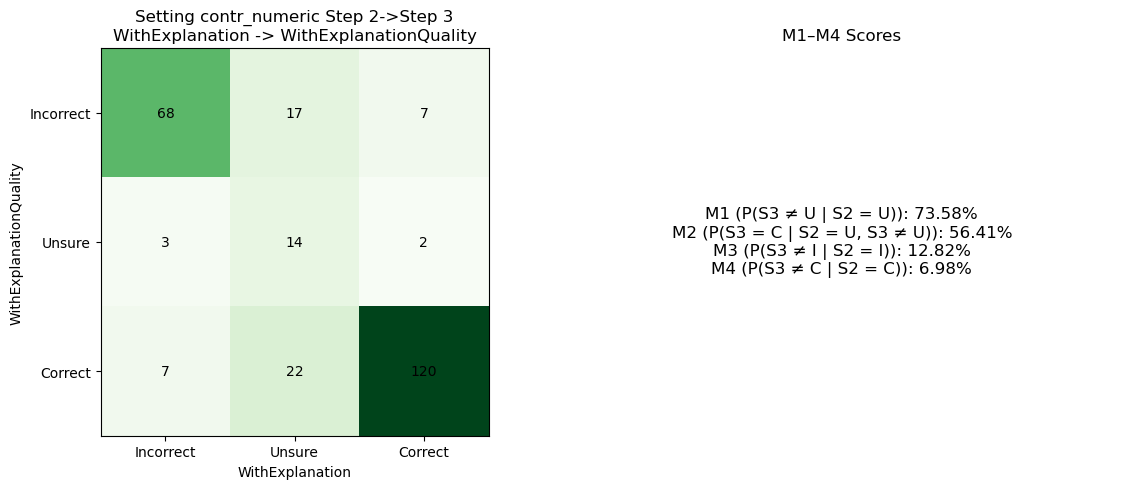


Processing setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'showbothmetrics_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
26 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 81.5% ±  2.4%	 11.5% ±  1.9%	 62.0% ±  6.9%	+0.044 ± 0.026
With Explanation         	 37.4% ±  3.0%	 34.8% ±  2.9%	 55.6% ±  3.8%	+0.070 ± 0.048
With Explanation + Quality	 11.1% ±  1.9%	 58.1% ±  3.0%	 65.4% ±  3.1%	+0.274 ± 0.055
81.5% ± 2.4%, 11.5% ± 1.9%, 62.0% ± 6.9%, 0.044 ± 0.026, 37.4% ± 3.0%, 34.8% ± 2.9%, 55.6% ± 3.8%, 0.070 ± 0.048, 11.1% ± 1.9%, 58.1% ± 3.0%, 65.4% ± 3.1%, 0.274 ± 0.055

Setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  37.4%		 +0.026 ± 0.044
Quality		  11.1%		 +0.204 ± 0.043

Setting: showbothmetrics_

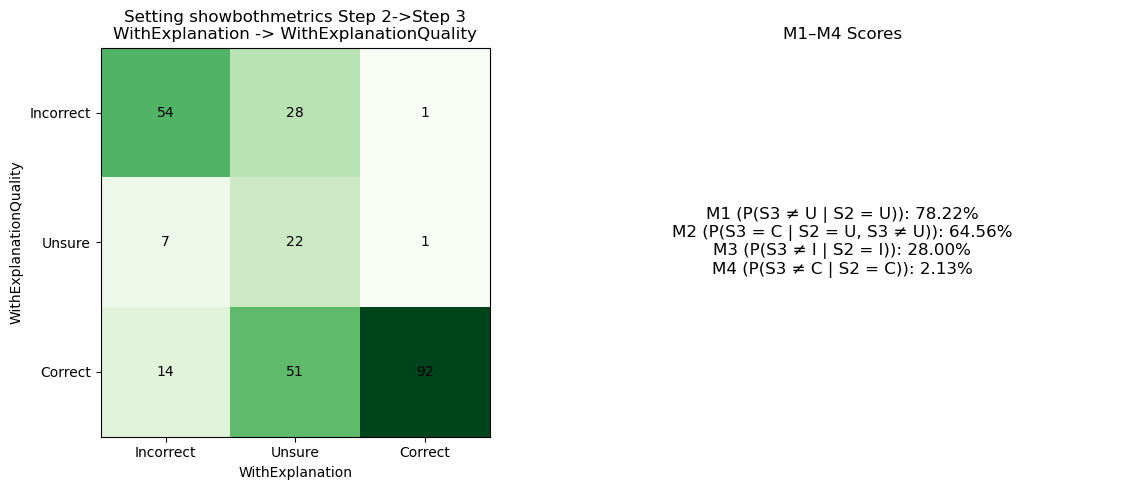


Processing setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Found 31 users in setting 'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0' with 31 total attempts.
31 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 85.2% ±  2.0%	  8.1% ±  1.5%	 54.3% ±  7.4%	+0.013 ± 0.022
With Explanation         	 34.2% ±  2.7%	 41.6% ±  2.8%	 63.2% ±  3.4%	+0.174 ± 0.045
With Explanation + Quality	  6.1% ±  1.4%	 59.4% ±  2.8%	 63.2% ±  2.8%	+0.248 ± 0.053
85.2% ± 2.0%, 8.1% ± 1.5%, 54.3% ± 7.4%, 0.013 ± 0.022, 34.2% ± 2.7%, 41.6% ± 2.8%, 63.2% ± 3.4%, 0.174 ± 0.045, 6.1% ± 1.4%, 59.4% ± 2.8%, 63.2% ± 2.8%, 0.248 ± 0.053

Setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  34.2%		 +0.161 ± 0.045
Quality		   6.1%		 +0.074 ± 0.036

Setting: avg

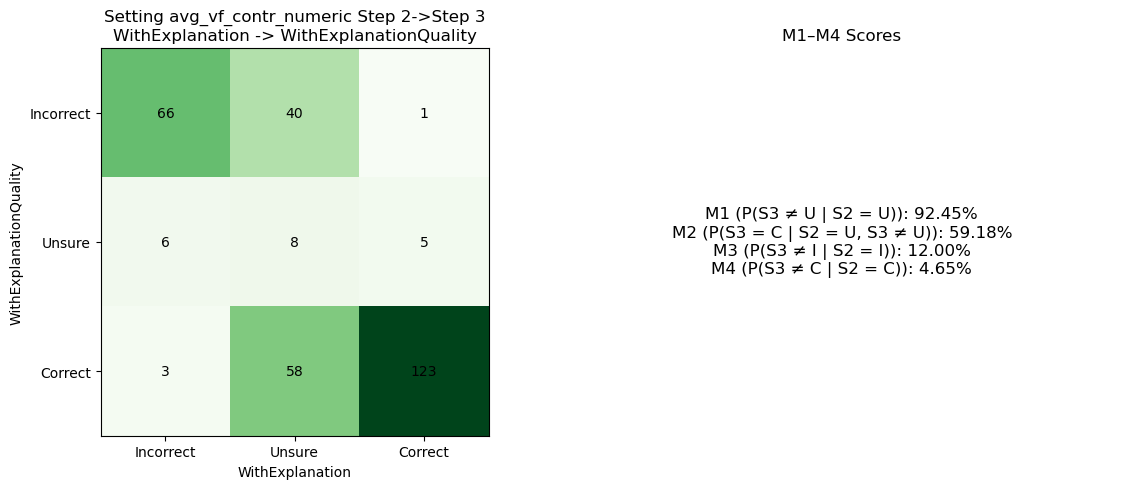


Processing setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Found 26 users in setting 'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0' with 29 total attempts.
24 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 72.2% ±  2.7%	 13.0% ±  2.0%	 46.7% ±  5.8%	-0.019 ± 0.032
With Explanation         	 24.8% ±  2.6%	 43.0% ±  3.0%	 57.1% ±  3.5%	+0.107 ± 0.052
With Explanation + Quality	  7.8% ±  1.6%	 58.5% ±  3.0%	 63.5% ±  3.1%	+0.248 ± 0.057
72.2% ± 2.7%, 13.0% ± 2.0%, 46.7% ± 5.8%, -0.019 ± 0.032, 24.8% ± 2.6%, 43.0% ± 3.0%, 57.1% ± 3.5%, 0.107 ± 0.052, 7.8% ± 1.6%, 58.5% ± 3.0%, 63.5% ± 3.1%, 0.248 ± 0.057

Setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  24.8%		 +0.126 ± 0.049
Quality		   7.8%		 +0.14

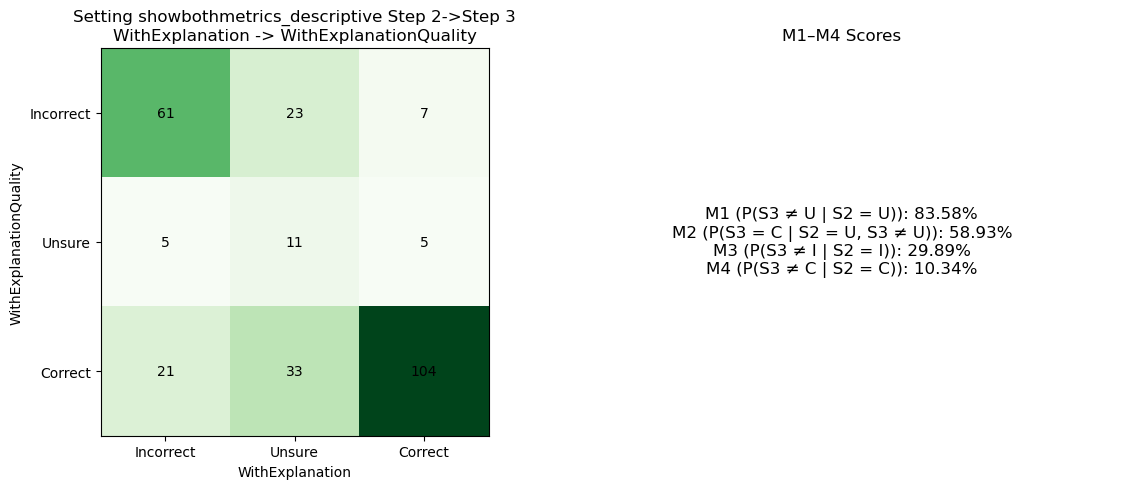


Processing setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'vf_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
24 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 79.2% ±  2.6%	 12.1% ±  2.1%	 58.0% ±  7.1%	+0.033 ± 0.029
With Explanation         	 24.2% ±  2.8%	 44.2% ±  3.2%	 58.2% ±  3.7%	+0.125 ± 0.056
With Explanation + Quality	  4.2% ±  1.3%	 61.3% ±  3.2%	 63.9% ±  3.2%	+0.267 ± 0.061
79.2% ± 2.6%, 12.1% ± 2.1%, 58.0% ± 7.1%, 0.033 ± 0.029, 24.2% ± 2.8%, 44.2% ± 3.2%, 58.2% ± 3.7%, 0.125 ± 0.056, 4.2% ± 1.3%, 61.3% ± 3.2%, 63.9% ± 3.2%, 0.267 ± 0.061

Setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  24.2%		 +0.092 ± 0.057
Quality		   4.2%		 +0.142 ± 0.046

Setting: vf_descriptive_llava

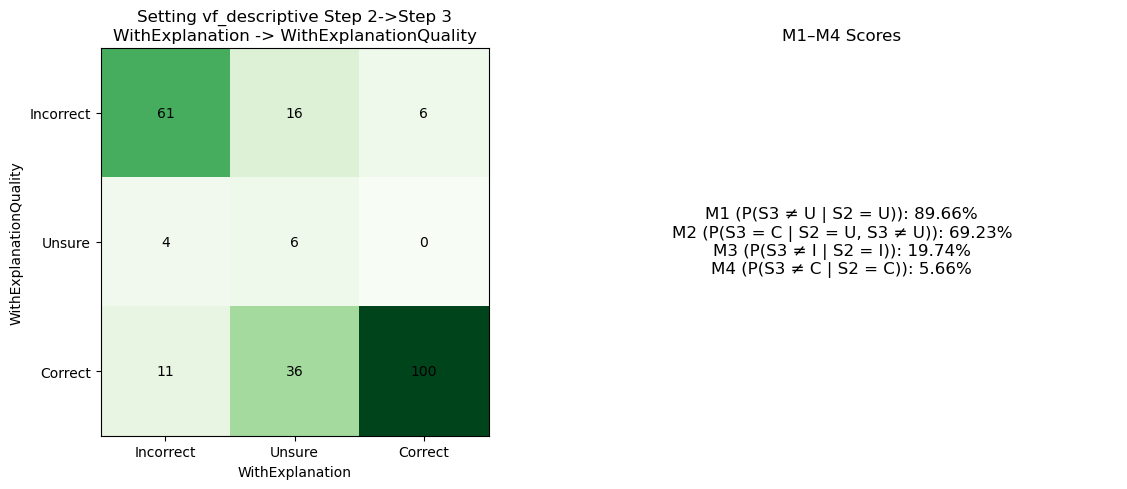


Processing setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users in setting 'contr_descriptive_llava1.5_with_image_q20_i10_s0' with 30 total attempts.
26 users remain after filtering.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
----------------------------------------------------------------------------------------------------
Answer Only              	 71.9% ±  2.8%	 18.5% ±  2.4%	 65.8% ±  5.6%	+0.088 ± 0.032
With Explanation         	 18.1% ±  2.4%	 50.8% ±  3.1%	 62.0% ±  3.3%	+0.196 ± 0.055
With Explanation + Quality	 10.0% ±  1.9%	 53.5% ±  3.1%	 59.4% ±  3.2%	+0.169 ± 0.058
71.9% ± 2.8%, 18.5% ± 2.4%, 65.8% ± 5.6%, 0.088 ± 0.032, 18.1% ± 2.4%, 50.8% ± 3.1%, 62.0% ± 3.3%, 0.196 ± 0.055, 10.0% ± 1.9%, 53.5% ± 3.1%, 59.4% ± 3.2%, 0.169 ± 0.058

Setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  18.1%		 +0.108 ± 0.051
Quality		  10.0%		 -0.027 ± 0.043

Setting: contr_desc

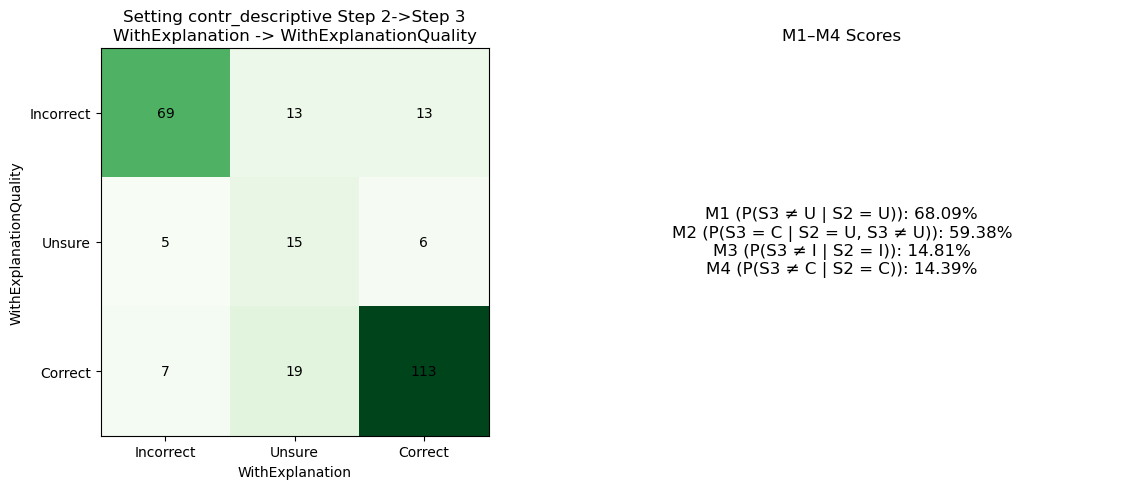

/tmp/ipykernel_56887/4064945344.py:323: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])


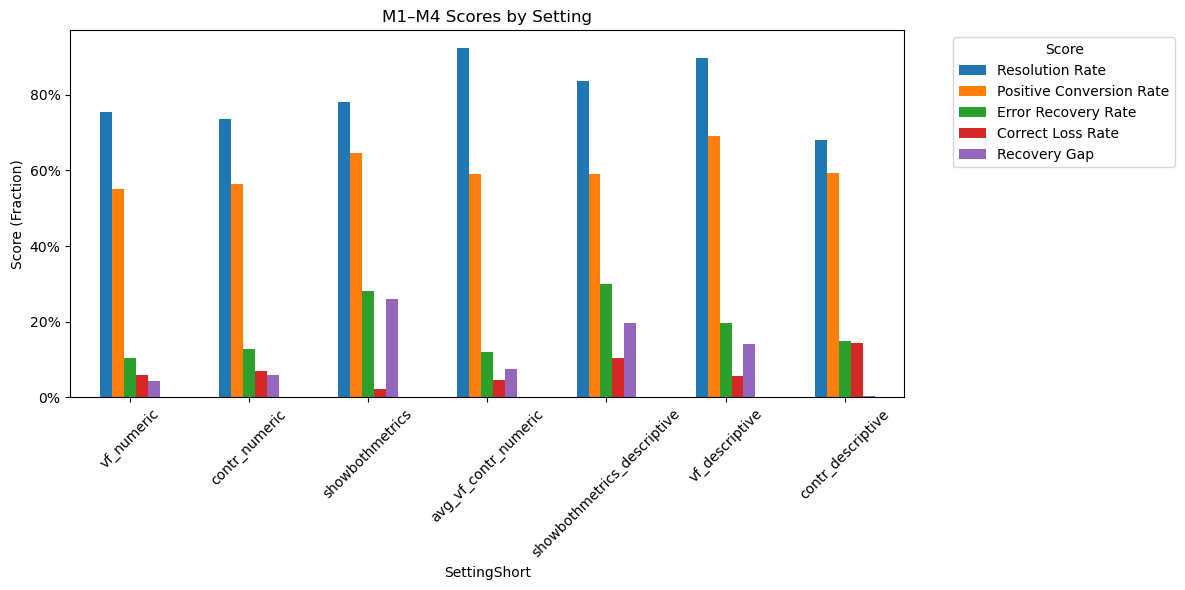

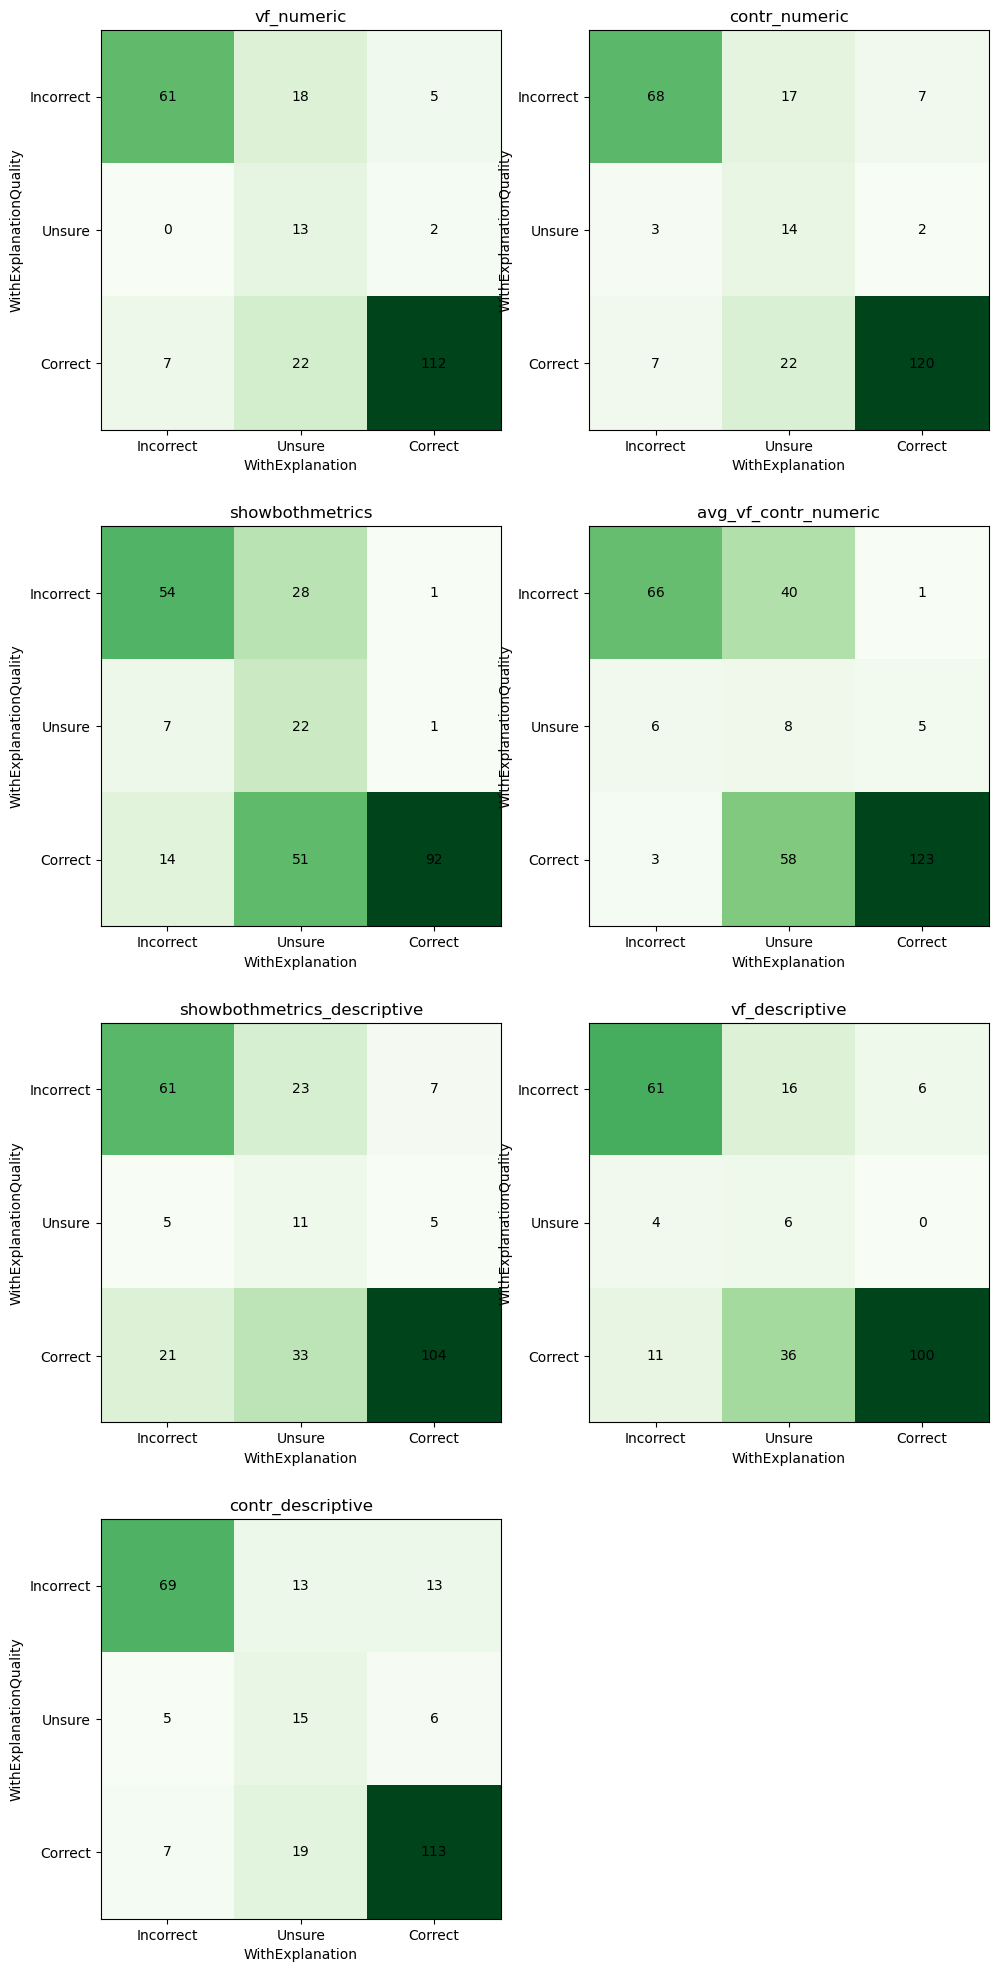

In [23]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# Filter: only include users with a certain unsure rate in 'answeronly' stage.
unsure_rate_threshold = 0.2

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(values):
    """Return the standard error of the given values."""
    n = len(values)
    return np.std(values, ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_unsure_rate(interactions, stage):
    """Compute the unsure rate (proportion of responses == 2) and its standard error."""
    preds = np.array([x['user_selections'][stage] for x in interactions])
    unsure_indicator = (preds == 2).astype(float)
    mean_unsure = np.mean(unsure_indicator)
    se_unsure = compute_se(unsure_indicator)
    return mean_unsure, se_unsure

def evaluate_answers(stage, instances):
    """
    For a given stage and list of interactions (instances), compute:
      - total accuracy (all instances, counting unsure as incorrect)
      - accuracy on non-unsure responses ("NotUnsureAcc")
      - unsure rate
      - utility (0 if unsure, 1 if correct, -1 if incorrect)
    Returns means and standard errors.
    """
    # Ground truth: 0 means AI is correct; 1 means AI is incorrect.
    ground_truths = np.array([1 - x['question']['prediction_is_correct'] for x in instances])
    preds = np.array([x['user_selections'][stage] for x in instances])
    
    # Total accuracy: count unsure (value 2) as incorrect.
    correct_all = ((preds != 2) & (preds == ground_truths)).astype(float)
    total_acc_mean = np.mean(correct_all)
    total_acc_se = compute_se(correct_all)
    
    # Accuracy for non-unsure responses.
    non_unsure_mask = (preds != 2)
    if np.sum(non_unsure_mask) > 0:
        correct_non_unsure = (preds[non_unsure_mask] == ground_truths[non_unsure_mask]).astype(float)
        acc_mean = np.mean(correct_non_unsure)
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan
    
    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_rate_mean = np.mean(unsure_indicator)
    unsure_rate_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; 1 if correct; -1 if incorrect.
    individual_utilities = np.array([
        0 if p == 2 else 1 - 2 * abs(p - gt)
        for p, gt in zip(preds, ground_truths)
    ])
    util_mean = np.mean(individual_utilities)
    util_se = compute_se(individual_utilities)
    
    return {
        'total_accuracy_mean': total_acc_mean,
        'total_accuracy_se': total_acc_se,
        'accuracy_mean': acc_mean,
        'accuracy_se': acc_se,
        'unsure_rate_mean': unsure_rate_mean,
        'unsure_rate_se': unsure_rate_se,
        'utility_mean': util_mean,
        'utility_se': util_se,
        'preds': preds,
        'ground_truths': ground_truths,
        'individual_utilities': individual_utilities,
    }

# ---------------------------
# Settings & Data Processing
# ---------------------------
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
]

USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# This list will collect the M1–M4 scores for each setting.
all_setting_scores = []

# This list will collect the confusion matrices for each setting.
all_confusion_matrices = []

# Process each setting.
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Aggregate sessions for each user.
    data = {}  # key: user_id, value: list of sessions
    for file in files:
        with open(file) as f:
            batch_data = json.load(f)
            for user_id, session in batch_data.items():
                data.setdefault(user_id, []).append(session)
    total_users = len(data)
    total_attempts = sum(len(sessions) for sessions in data.values())
    print(f"Found {total_users} users in setting '{setting}' with {total_attempts} total attempts.")
    
    filtered_instances = []
    count_filtered_users = 0
    for user, sessions in data.items():
        interactions = []
        for session in sessions:
            interactions.extend(session['interactions'])
        mean_unsure, _ = compute_unsure_rate(interactions, 'answeronly')
        if mean_unsure >= unsure_rate_threshold:
            filtered_instances.extend(interactions)
            count_filtered_users += 1
    print(f"{count_filtered_users} users remain after filtering.")
    
    if len(filtered_instances) == 0:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue

    # Evaluate each stage.
    answeronly_results = evaluate_answers('answeronly', filtered_instances)
    withexplanation_results = evaluate_answers('withexplanation', filtered_instances)
    withexplanationquality_results = evaluate_answers('withexplanationquality', filtered_instances)
    
    # ---------------------------
    # 1. Print Per-Stage Scores
    # ---------------------------
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    print("-" * 100)
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stage_results = [answeronly_results, withexplanation_results, withexplanationquality_results]
    
    csv_prints = [] # For copiable csv outputs
    for name, res in zip(stage_names, stage_results):
        # Multiply rates by 100 for percentage printing.
        print(f"{name:<25}\t"
              f"{res['unsure_rate_mean']*100:5.1f}% ± {res['unsure_rate_se']*100:4.1f}%\t"
              f"{res['total_accuracy_mean']*100:5.1f}% ± {res['total_accuracy_se']*100:4.1f}%\t"
              f"{res['accuracy_mean']*100:5.1f}% ± {res['accuracy_se']*100:4.1f}%\t"
              f"{res['utility_mean']:+.3f} ± {res['utility_se']:.3f}")
        csv_prints.append(f"{res['unsure_rate_mean']*100:.1f}% ± {res['unsure_rate_se']*100:.1f}%, "
                            f"{res['total_accuracy_mean']*100:.1f}% ± {res['total_accuracy_se']*100:.1f}%, "
                            f"{res['accuracy_mean']*100:.1f}% ± {res['accuracy_se']*100:.1f}%, "
                            f"{res['utility_mean']:.3f} ± {res['utility_se']:.3f}")
        
    print(", ".join(csv_prints))
        
        
    
    # ---------------------------
    # 2. Print Utility Gains (Over Previous Stage)
    # ---------------------------
    # Compute differences for interactions (they align since we used the same filtered_instances).
    explanation_gain = withexplanation_results['individual_utilities'] - answeronly_results['individual_utilities']
    quality_gain = withexplanationquality_results['individual_utilities'] - withexplanation_results['individual_utilities']
    
    expl_gain_mean = np.mean(explanation_gain)
    expl_gain_se = compute_se(explanation_gain)
    qual_gain_mean = np.mean(quality_gain)
    qual_gain_se = compute_se(quality_gain)
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    # For the "Explanation" stage, print its unsure rate and the gain (compared to Answer Only).
    print(f"Explanation\t {withexplanation_results['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {withexplanationquality_results['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")

    # ---------------------------
    # 3. Compute Confusion Matrix & M1–M4 (Step 2 -> Step 3)
    # ---------------------------
    # Use the utility values from 'withexplanation' (stage2) and 'withexplanationquality' (stage3).
    # Define mapping: -1 -> row/col 0, 0 -> row/col 1, 1 -> row/col 2.
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']

    # Initialize a 3x3 confusion matrix.
    cm = np.zeros((3, 3), dtype=int)
    for u2, u3 in zip(withexplanation_results['individual_utilities'], 
                    withexplanationquality_results['individual_utilities']):
        cm[mapping[u2], mapping[u3]] += 1

    # For display only, transpose the confusion matrix.
    cm_transposed = cm.T

    # Print the transposed confusion matrix.
    print(f"\nSetting: {setting} Step 2->Step 3 (transposed)")
    header = "\t\t" + "\t".join(label_names)
    print(header)
    for i, label in enumerate(label_names):
        row_counts = "\t\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_counts}")
        
    # Store this confusion matrix for later plotting.
    all_confusion_matrices.append((setting, cm_transposed))

    # Helper: count transitions between given utility values (remains unchanged).
    def count_transitions(val2, val3):
        return sum(1 for u2, u3 in zip(withexplanation_results['individual_utilities'],
                                        withexplanationquality_results['individual_utilities'])
                if u2 == val2 and u3 == val3)

    # M1, M2, M3, M4 are computed as before.
    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    
    # Collect scores for the bar plot.
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    
    # ---------------------------
    # NEW: Print Examples where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    example_count = 0
    for interaction in filtered_instances:
        stage2_pred = interaction['user_selections'].get('withexplanation')
        stage3_pred = interaction['user_selections'].get('withexplanationquality')
        ground_truth = 1 - interaction['question']['prediction_is_correct']
        # Check that stage 2 (With Explanation) is not unsure and is correct,
        # and that stage 3 (With Explanation + Quality) is not unsure and is incorrect.
        if stage2_pred != 2 and stage2_pred == ground_truth and stage3_pred != 2 and stage3_pred != ground_truth:
            print(json.dumps(interaction, indent=2))
            example_count += 1
            if example_count >= 5:
                break
    if example_count == 0:
        print("No examples found.")

    # ---------------------------
    # 4. Plot Transposed Confusion Matrix & M1–M4 Scores
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot the transposed confusion matrix.
    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\nWithExplanation -> WithExplanationQuality")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    # After transposition, the x-axis corresponds to the original stage2 labels,
    # and the y-axis to stage3 labels.
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    # Annotate each cell.
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")

    # Plot M1–M4 scores in a text panel.
    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")

    plt.tight_layout()
    plt.show()

# ---------------------------
# 5. Plot Bar Plot for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    
    # Add new column: Recovery Gap = Error Recovery Rate (M3) - Correct Loss Rate (M4)
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    
    df_scores = df_scores.set_index("SettingShort")
    
    # Create a grouped bar plot.
    ax = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate", "Correct Loss Rate", "Recovery Gap"]].plot(
        kind='bar', figsize=(12, 6)
    )
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("M1–M4 Scores by Setting")
    # Format the y-axis as percentage if desired.
    vals = ax.get_yticks()
    ax.set_yticklabels([f"{v*100:.0f}%" for v in vals])
    # rotate x-tick labels for better readability.
    plt.xticks(rotation=45)
    
    plt.legend(title="Score", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
# ---------------------------
# 6. Plot a Large Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    # Determine grid dimensions: 2 columns and enough rows to cover all settings.
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    
    # Flatten the axes array for easy iteration.
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        # Annotate each cell.
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    # Hide any extra subplots if the grid is larger than the number of settings.
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()


Processing setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Found 28 users and 300 interactions for setting 'vf_numeric_llava1.5_with_image_q20_i10_s0'.
27 users remain after filtering; 290 interactions remain.
Batch 000_3users need 1 more users to annotate.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 64.5% ±  2.8%	 23.8% ±  2.5%	 67.0% ±  4.7%	+0.121 ± 0.034
With Explanation         	 18.3% ±  2.3%	 52.1% ±  2.9%	 63.7% ±  3.1%	+0.224 ± 0.052
With Explanation + Quality	  5.2% ±  1.3%	 60.7% ±  2.9%	 64.0% ±  2.9%	+0.266 ± 0.055
 64.5% ±  2.8%,  23.8% ±  2.5%,  67.0% ±  4.7%, +0.121 ± 0.034,  18.3% ±  2.3%,  52.1% ±  2.9%,  63.7% ±  3.1%, +0.224 ± 0.052,   5.2% ±  1.3%,  60.7% ±  2.9%,  64.0% ±  2.9%, +0.266 ± 0.055

Setting: vf_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  18.3%		 +0.103 ± 0.047
Quality		   5.2%		 +0.041 ± 0.035

Setting: vf_numeric_llava1.5_with_image_q20_i10_

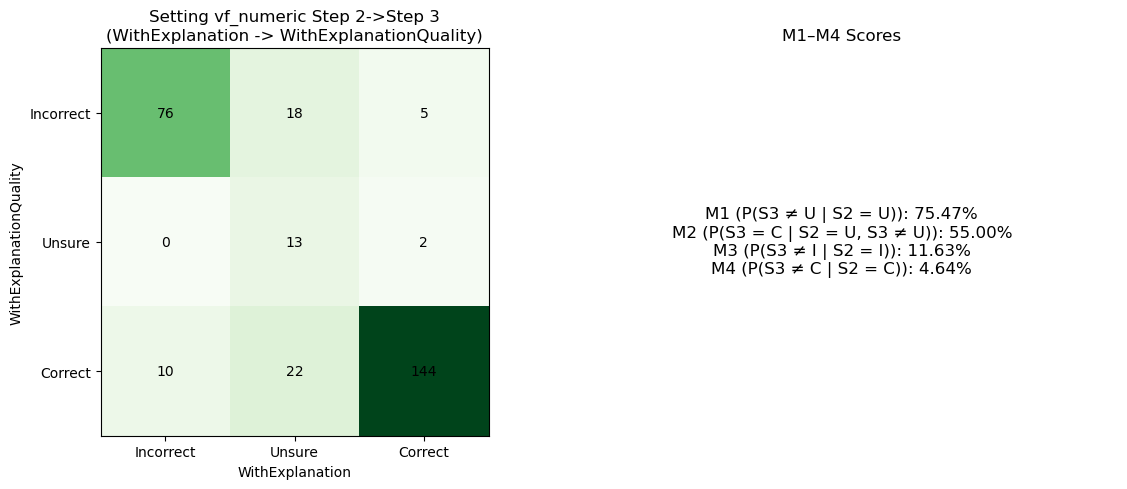


Processing setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Found 30 users and 300 interactions for setting 'contr_numeric_llava1.5_with_image_q20_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 65.7% ±  2.7%	 20.0% ±  2.3%	 58.3% ±  4.9%	+0.057 ± 0.034
With Explanation         	 17.7% ±  2.2%	 50.0% ±  2.9%	 60.7% ±  3.1%	+0.177 ± 0.051
With Explanation + Quality	  6.3% ±  1.4%	 57.3% ±  2.9%	 61.2% ±  2.9%	+0.210 ± 0.055
 65.7% ±  2.7%,  20.0% ±  2.3%,  58.3% ±  4.9%, +0.057 ± 0.034,  17.7% ±  2.2%,  50.0% ±  2.9%,  60.7% ±  3.1%, +0.177 ± 0.051,   6.3% ±  1.4%,  57.3% ±  2.9%,  61.2% ±  2.9%, +0.210 ± 0.055

Setting: contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  17.7%		 +0.120 ± 0.046
Quality		   6.3%		 +0.033 ± 0.037

Setting: contr_numeric_llava1.5_with_image_q20_i10_s0 Step 2 -> Step 3 (transposed)
		I

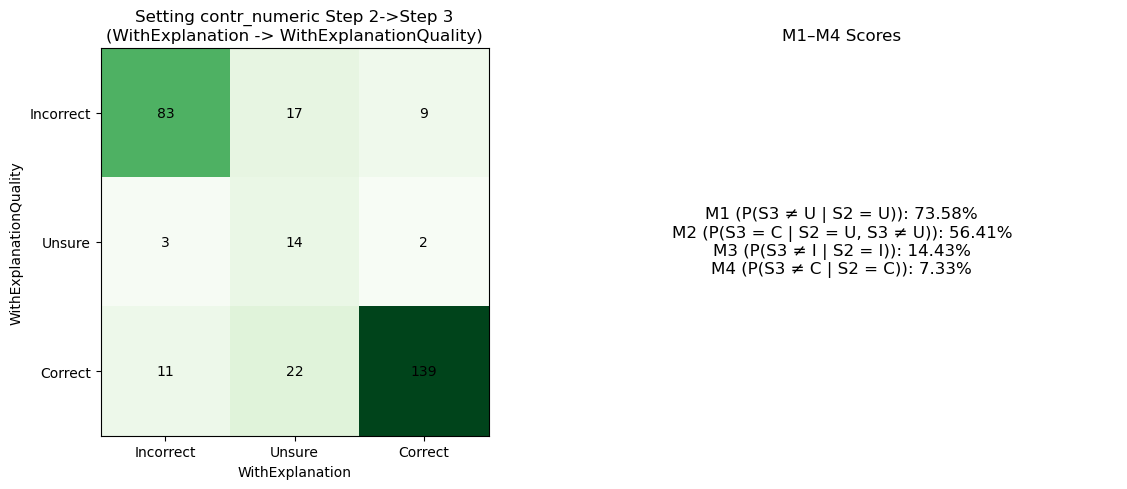


Processing setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users and 300 interactions for setting 'vf_descriptive_llava1.5_with_image_q20_i10_s0'.
28 users remain after filtering; 280 interactions remain.
Batch 003_3users need 1 more users to annotate.
Batch 009_3users need 1 more users to annotate.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 67.1% ±  2.8%	 20.0% ±  2.4%	 60.9% ±  5.1%	+0.071 ± 0.034
With Explanation         	 21.1% ±  2.4%	 47.1% ±  3.0%	 59.7% ±  3.3%	+0.154 ± 0.052
With Explanation + Quality	  3.6% ±  1.1%	 60.7% ±  2.9%	 63.0% ±  2.9%	+0.250 ± 0.057
 67.1% ±  2.8%,  20.0% ±  2.4%,  60.9% ±  5.1%, +0.071 ± 0.034,  21.1% ±  2.4%,  47.1% ±  3.0%,  59.7% ±  3.3%, +0.154 ± 0.052,   3.6% ±  1.1%,  60.7% ±  2.9%,  63.0% ±  2.9%, +0.250 ± 0.057

Setting: vf_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  21.1%		 +0.082 ± 0.054
Quality		   3.6%		 +0.0

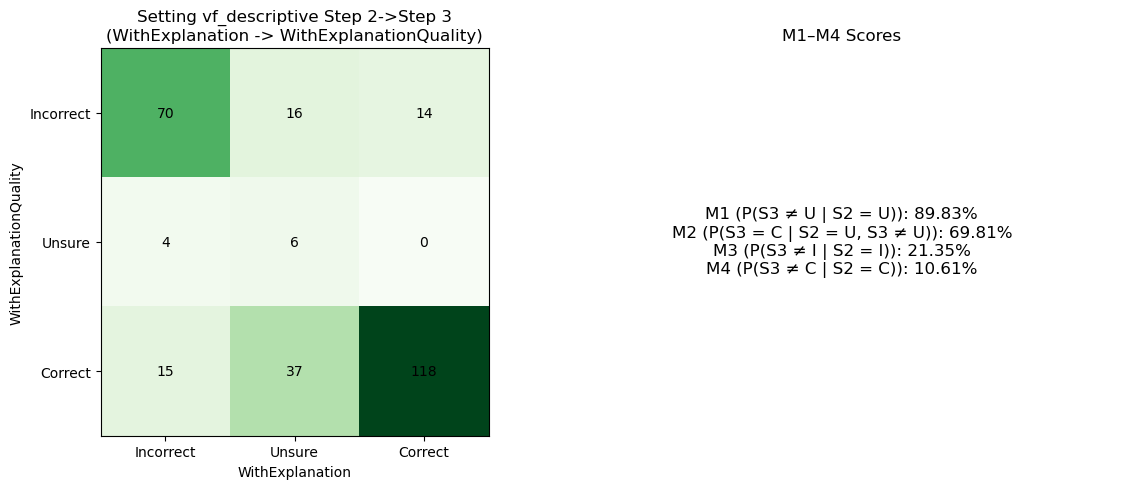


Processing setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Found 30 users and 300 interactions for setting 'contr_descriptive_llava1.5_with_image_q20_i10_s0'.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 63.0% ±  2.8%	 24.0% ±  2.5%	 64.9% ±  4.6%	+0.110 ± 0.035
With Explanation         	 17.0% ±  2.2%	 52.3% ±  2.9%	 63.1% ±  3.1%	+0.217 ± 0.051
With Explanation + Quality	  8.7% ±  1.6%	 54.3% ±  2.9%	 59.5% ±  3.0%	+0.173 ± 0.054
 63.0% ±  2.8%,  24.0% ±  2.5%,  64.9% ±  4.6%, +0.110 ± 0.035,  17.0% ±  2.2%,  52.3% ±  2.9%,  63.1% ±  3.1%, +0.217 ± 0.051,   8.7% ±  1.6%,  54.3% ±  2.9%,  59.5% ±  3.0%, +0.173 ± 0.054

Setting: contr_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  17.0%		 +0.107 ± 0.047
Quality		   8.7%		 -0.043 ± 0.041

Setting: contr_descriptive_llava1.5_with_image_q20_i10_s0 Step 2 -> Step 3 

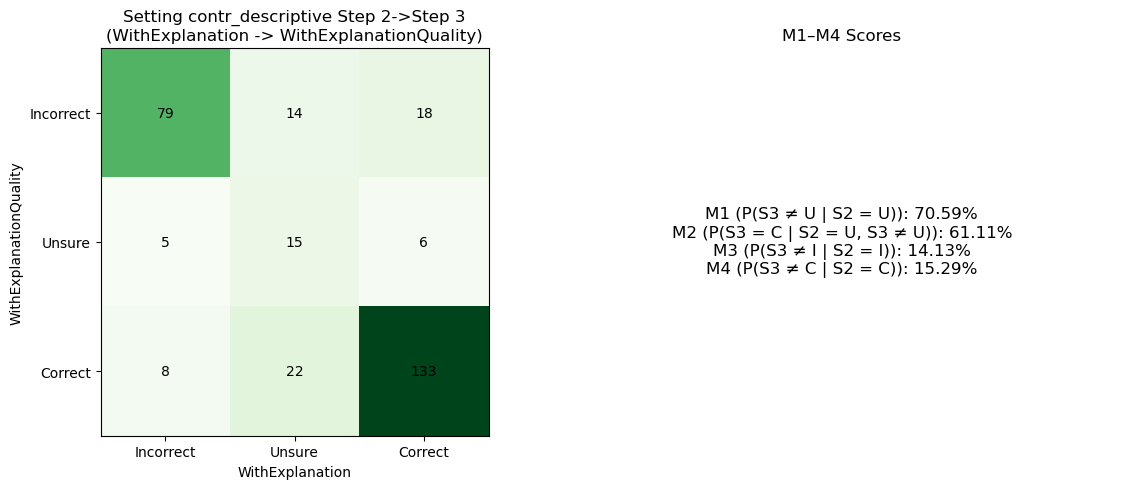


Processing setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Found 31 users and 310 interactions for setting 'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0'.
Batch 009_3users has been annotated 40 times, exceeding 30 annotations. Shortening to first 30 annotations.
30 users remain after filtering; 300 interactions remain.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 86.0% ±  2.0%	  7.7% ±  1.5%	 54.8% ±  7.8%	+0.013 ± 0.022
With Explanation         	 35.3% ±  2.8%	 41.3% ±  2.8%	 63.9% ±  3.5%	+0.180 ± 0.045
With Explanation + Quality	  6.0% ±  1.4%	 59.7% ±  2.8%	 63.5% ±  2.9%	+0.253 ± 0.054
 86.0% ±  2.0%,   7.7% ±  1.5%,  54.8% ±  7.8%, +0.013 ± 0.022,  35.3% ±  2.8%,  41.3% ±  2.8%,  63.9% ±  3.5%, +0.180 ± 0.045,   6.0% ±  1.4%,  59.7% ±  2.8%,  63.5% ±  2.9%, +0.253 ± 0.054

Setting: avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  35.3%		 +0.167 ±

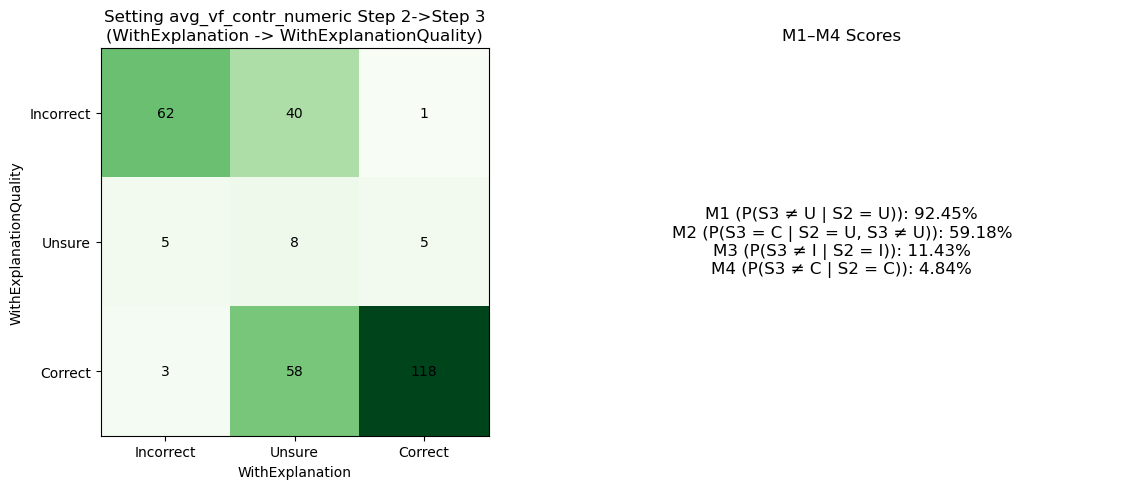


Processing setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Found 30 users and 310 interactions for setting 'showbothmetrics_llava1.5_with_image_q20_i10_s0'.
Batch 000 has been annotated 40 times, exceeding 30 annotations. Shortening to first 30 annotations.
27 users remain after filtering; 280 interactions remain.
Batch 001_3users need 1 more users to annotate.
Batch 009_3users need 1 more users to annotate.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 75.7% ±  2.6%	 14.3% ±  2.1%	 58.8% ±  6.0%	+0.043 ± 0.029
With Explanation         	 34.6% ±  2.8%	 36.1% ±  2.9%	 55.2% ±  3.7%	+0.068 ± 0.048
With Explanation + Quality	  9.6% ±  1.8%	 58.9% ±  2.9%	 65.2% ±  3.0%	+0.275 ± 0.054
 75.7% ±  2.6%,  14.3% ±  2.1%,  58.8% ±  6.0%, +0.043 ± 0.029,  34.6% ±  2.8%,  36.1% ±  2.9%,  55.2% ±  3.7%, +0.068 ± 0.048,   9.6% ±  1.8%,  58.9% ±  2.9%,  65.2% ±  3.0%, +0.275 ± 0.054

Setting: showbothmetrics_llava1.5_with_image_q20_i10_s0
Sta

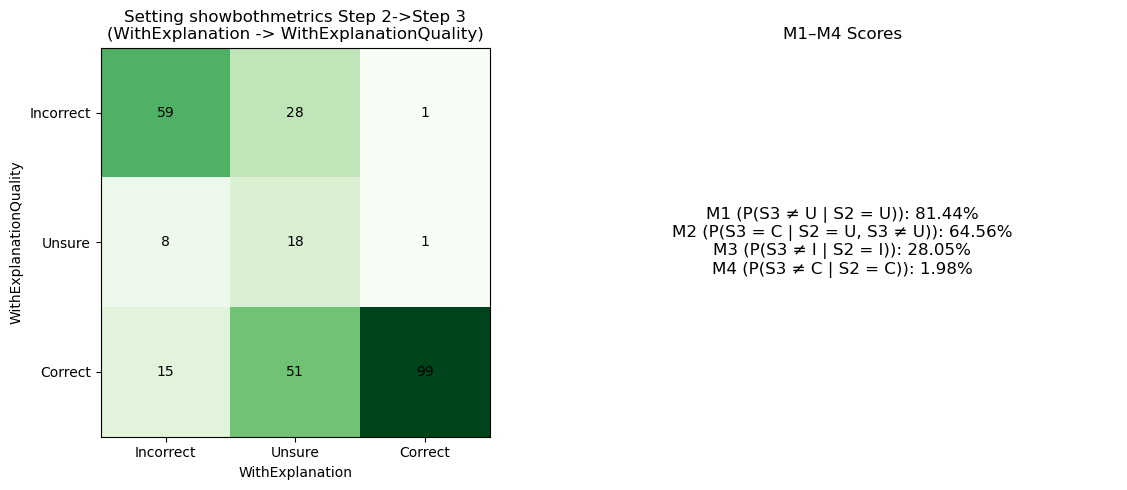


Processing setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Found 26 users and 290 interactions for setting 'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0'.
25 users remain after filtering; 280 interactions remain.
Batch 005_3users need 2 more users to annotate.

Stage                    	Unsure Rate	TotalAcc	NotUnsureAcc	Utility
Answer Only              	 69.6% ±  2.8%	 14.3% ±  2.1%	 47.1% ±  5.4%	-0.018 ± 0.033
With Explanation         	 23.9% ±  2.6%	 43.9% ±  3.0%	 57.7% ±  3.4%	+0.118 ± 0.052
With Explanation + Quality	  7.5% ±  1.6%	 60.0% ±  2.9%	 64.9% ±  3.0%	+0.275 ± 0.055
 69.6% ±  2.8%,  14.3% ±  2.1%,  47.1% ±  5.4%, -0.018 ± 0.033,  23.9% ±  2.6%,  43.9% ±  3.0%,  57.7% ±  3.4%, +0.118 ± 0.052,   7.5% ±  1.6%,  60.0% ±  2.9%,  64.9% ±  3.0%, +0.275 ± 0.055

Setting: showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0
Stage		Unsure Rate	Utility over previous stage
Explanation	  23.9%		 +0.136 ± 0.049
Quality		   7.5%		 +0.157 ± 0.04

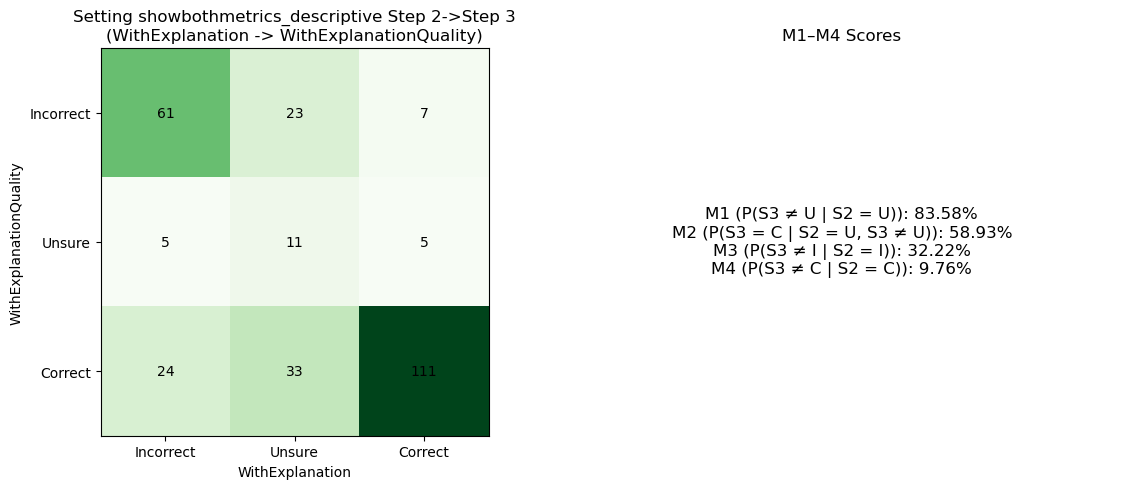

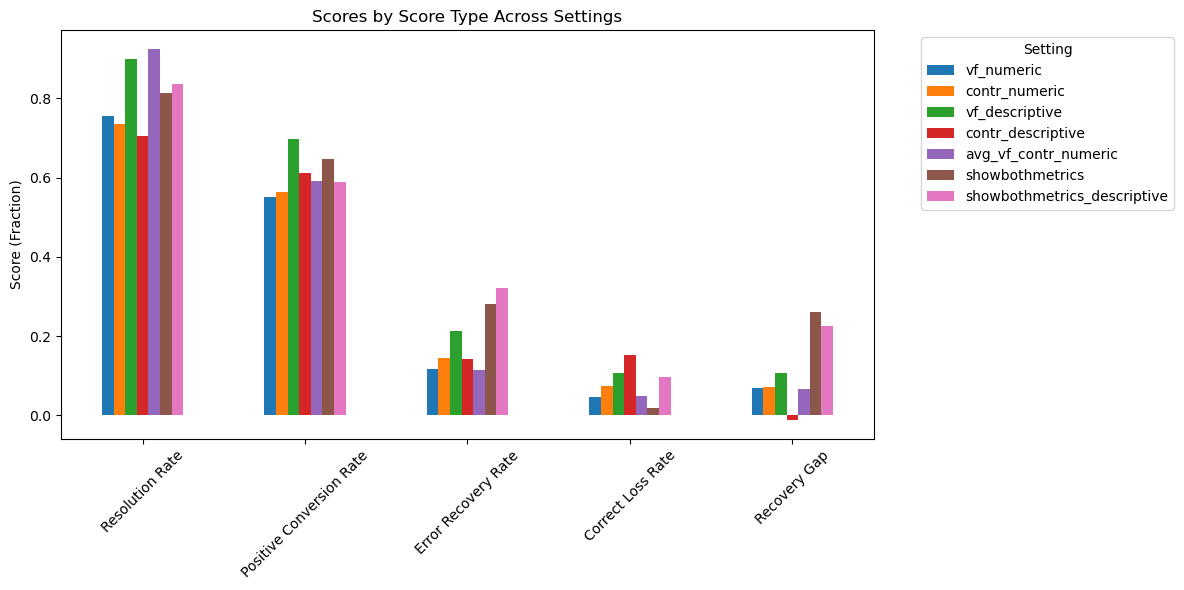

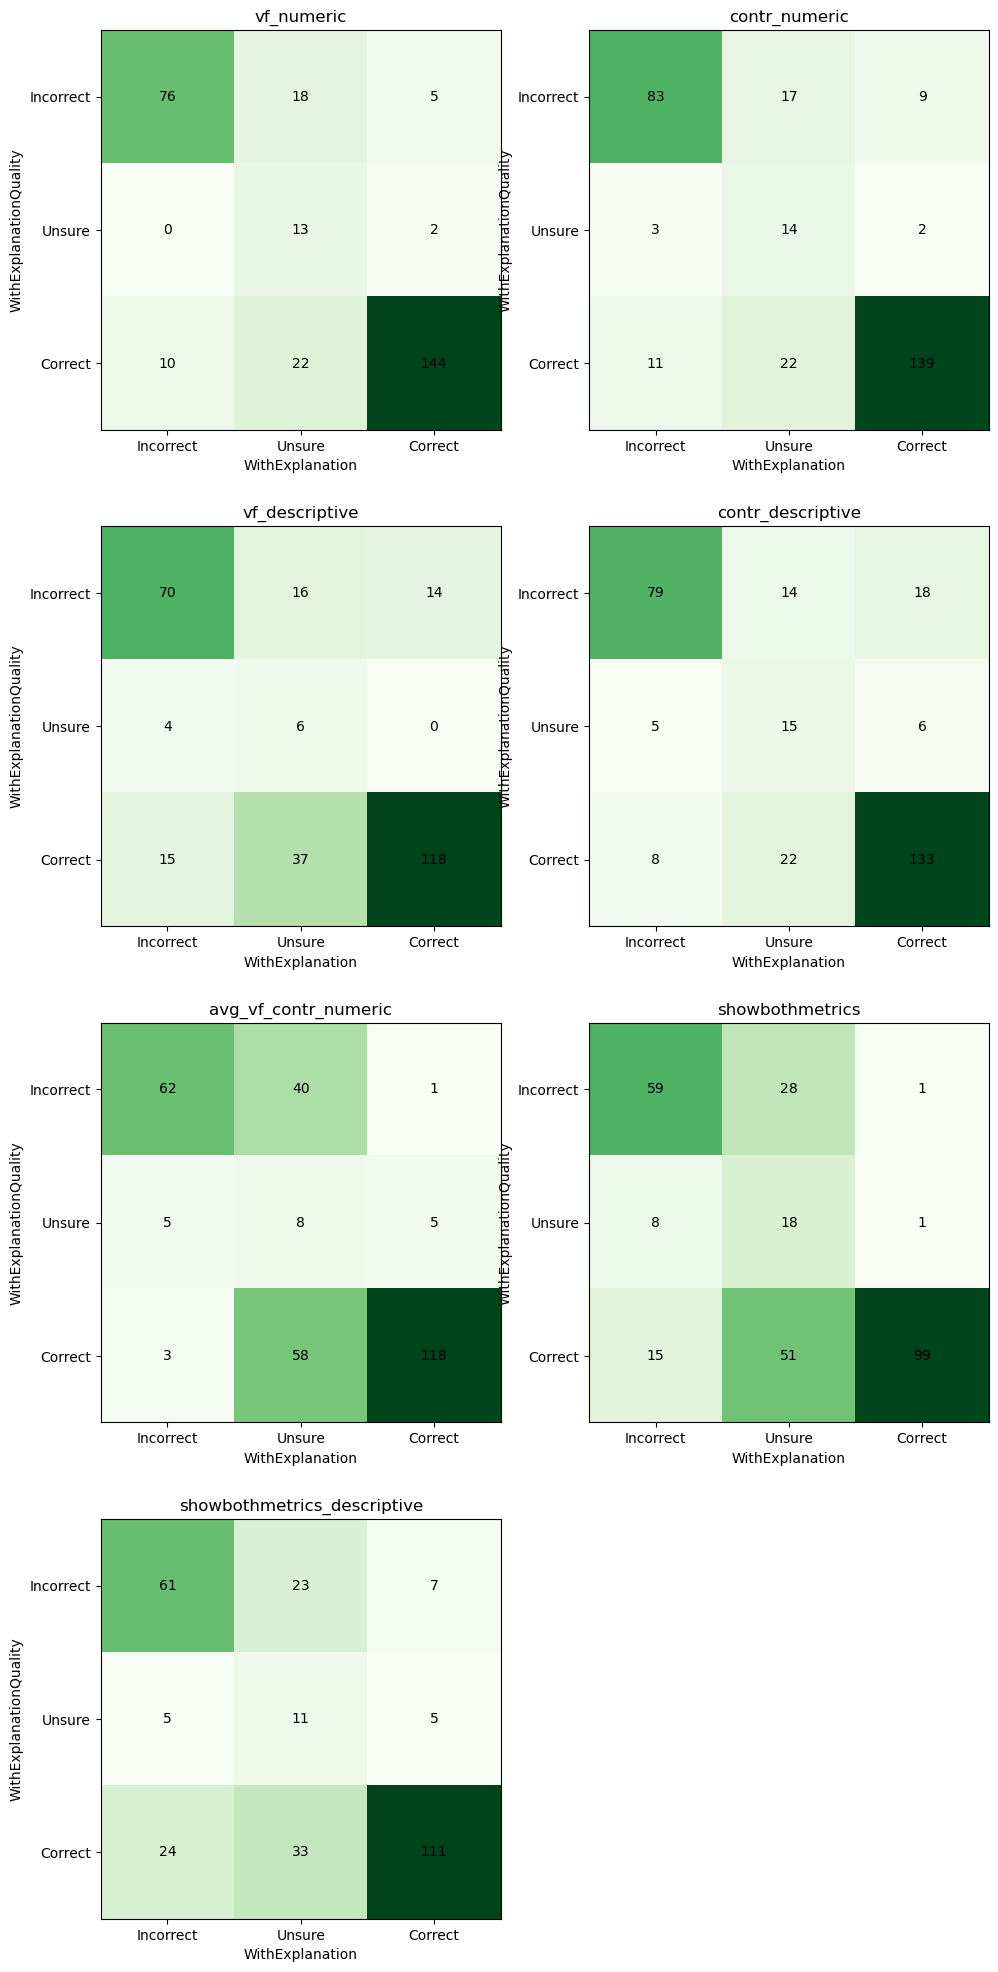

In [2]:
import json
import glob, os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Helper Functions
# ---------------------------
def compute_se(series):
    """Compute the standard error on a pandas Series."""
    n = series.count()
    return series.std(ddof=1) / np.sqrt(n) if n > 1 else 0

def compute_metrics(df, stage):
    """
    Given a DataFrame of interactions (with a column for the stage and a column for ground_truth),
    compute:
      - Total accuracy (unsure responses, coded as 2, count as incorrect)
      - Accuracy on non-unsure responses ("NotUnsureAcc")
      - Unsure rate
      - Utility (0 if unsure; 1 if correct; -1 if incorrect)
    Returns also the computed utility as a Series.
    """
    preds = df[stage]
    # Total accuracy: count unsure as incorrect.
    correct_all = ((preds != 2) & (preds == df['ground_truth'])).astype(float)
    total_acc_mean = correct_all.mean()
    total_acc_se = compute_se(correct_all)
    
    # Accuracy on non-unsure responses.
    non_unsure = preds != 2
    if non_unsure.sum() > 0:
        correct_non_unsure = (df.loc[non_unsure, stage] == df.loc[non_unsure, 'ground_truth']).astype(float)
        acc_mean = correct_non_unsure.mean()
        acc_se = compute_se(correct_non_unsure)
    else:
        acc_mean, acc_se = np.nan, np.nan

    # Unsure rate.
    unsure_indicator = (preds == 2).astype(float)
    unsure_mean = unsure_indicator.mean()
    unsure_se = compute_se(unsure_indicator)
    
    # Utility: 0 if unsure; else 1 if correct, -1 if incorrect.
    # (i.e., 1 - 2*abs(pred - ground_truth))
    def calc_util(row):
        p = row[stage]
        gt = row['ground_truth']
        return 0 if p == 2 else 1 - 2*abs(p - gt)
    utility = df.apply(calc_util, axis=1)
    util_mean = utility.mean()
    util_se = compute_se(utility)
    
    return total_acc_mean, total_acc_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, utility

# ---------------------------
# Settings and Directories
# ---------------------------
settings = [
    'vf_numeric_llava1.5_with_image_q20_i10_s0',
    'contr_numeric_llava1.5_with_image_q20_i10_s0',
    'vf_descriptive_llava1.5_with_image_q20_i10_s0',
    'contr_descriptive_llava1.5_with_image_q20_i10_s0',
    'avg_vf_contr_numeric_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_llava1.5_with_image_q20_i10_s0',
    'showbothmetrics_descriptive_llava1.5_with_image_q20_i10_s0',
]
USER_STUDIES_DIR = "/home/shared/vlm_rationales_eval/user_studies_data/"

# To store scores and confusion matrices across settings
all_setting_scores = []
all_confusion_matrices = []
consistent_choice_threshold = 0.9  # 90% threshold

# ---------------------------
# Process Each Setting via DataFrame
# ---------------------------
for setting in settings:
    print(f"\nProcessing setting: {setting}")
    pattern = os.path.join(USER_STUDIES_DIR, "prolific_batches", "batch_interaction_data", setting, "*.json")
    files = glob.glob(pattern)
    
    # Create a list of records (each record is an interaction)
    records = []
    for file in files:
        batch_id = os.path.basename(file).split('.')[0]
        with open(file) as f:
            batch_data = json.load(f)
        # Each file contains sessions for multiple users.
        for user_id, session in batch_data.items():
            interactions = session['interactions']
            for interaction in interactions:
                rec = {
                    'user_id': user_id,
                    'batch': batch_id,
                    'question_i': interaction['question_i'],
                    'answeronly': interaction['user_selections'].get('answeronly'),
                    'withexplanation': interaction['user_selections'].get('withexplanation'),
                    'withexplanationquality': interaction['user_selections'].get('withexplanationquality'),
                    # Ground truth: defined as 1 - prediction_is_correct.
                    'ground_truth': 1 - interaction['question']['prediction_is_correct']
                }
                records.append(rec)
    
    # Build DataFrame from the records.
    df = pd.DataFrame(records)
    print(f"Found {df['user_id'].nunique()} users and {len(df)} interactions for setting '{setting}'.")
    
    # ---------------------------
    # Filter Users Based on Consistency
    # ---------------------------
    # For each user, look at all responses across all stages and drop users
    # where one response (0, 1, or 2) comprises ≥90% of their responses.
    def user_is_valid(group):
        responses = pd.concat([group['answeronly'], group['withexplanation'], group['withexplanationquality']])
        if responses.empty:
            return False
        norm_counts = responses.value_counts(normalize=True)
        if norm_counts.max() >= consistent_choice_threshold:
            # If desired, you could print which user is filtered out.
            # print(f"User {group.name} filtered out; response distribution: {norm_counts.to_dict()}")
            return False
        return True

    df_valid = df.groupby('user_id').filter(user_is_valid)

    if df_valid.empty:
        print("No interactions remain after filtering. Skipping evaluation for this setting.")
        continue
        
    # ---------------------------
    # Filter Batches with More Than 30 Annotations
    # ---------------------------
    # For each batch, if it has been annotated more than 30 times (i.e. more than three users,
    # assuming each user annotates about 10 interactions), print the annotation count
    # and then shorten the batch to include only the first 30 annotations.
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count > 30:
            print(f"Batch {batch} has been annotated {count} times, exceeding 30 annotations. Shortening to first 30 annotations.")
    # Group by 'batch' and take only the first 30 entries for each batch
    df_valid = df_valid.groupby('batch').apply(lambda g: g.head(30)).reset_index(drop=True)
    print(f"{df_valid['user_id'].nunique()} users remain after filtering; {len(df_valid)} interactions remain.")
    
    
    # Indicate which batches need to add users
    batch_counts = df_valid['batch'].value_counts()
    for batch, count in batch_counts.items():
        if count % 10: raise ValueError('# Annotation should be divisible by 10, but found not??')
        count = count // 10
        if count > 3:
            raise ValueError(f"After filtering, # users taking the batch should not > 3??")
        diff = 3 - count
        if diff != 0:
            print(f"Batch {batch} need {diff} more users to annotate.")
    
    
    # ---------------------------
    # Compute Metrics for Each Stage Using DataFrames
    # ---------------------------
    stage_names = ['Answer Only', 'With Explanation', 'With Explanation + Quality']
    stages = ['answeronly', 'withexplanation', 'withexplanationquality']
    metrics = {}
    utilities = {}
    csv_prints = []
    print("\nStage                    \tUnsure Rate\tTotalAcc\tNotUnsureAcc\tUtility")
    for stage, name in zip(stages, stage_names):
        tot_acc, tot_se, acc_mean, acc_se, unsure_mean, unsure_se, util_mean, util_se, util_series = compute_metrics(df_valid, stage)
        metrics[stage] = {
            'total_accuracy_mean': tot_acc,
            'total_accuracy_se': tot_se,
            'accuracy_mean': acc_mean,
            'accuracy_se': acc_se,
            'unsure_rate_mean': unsure_mean,
            'unsure_rate_se': unsure_se,
            'utility_mean': util_mean,
            'utility_se': util_se
        }
        utilities[stage] = util_series
        print(f"{name:<25}\t{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%\t"
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%\t"
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%\t"
              f"{util_mean:+.3f} ± {util_se:.3f}")
        csv_prints.append(f"{unsure_mean*100:5.1f}% ± {unsure_se*100:4.1f}%, "
              f"{tot_acc*100:5.1f}% ± {tot_se*100:4.1f}%, "
              f"{acc_mean*100:5.1f}% ± {acc_se*100:4.1f}%, "
              f"{util_mean:+.3f} ± {util_se:.3f}")
        
    print(", ".join(csv_prints))

    # ---------------------------
    # Utility Gains Between Stages
    # ---------------------------
    gain_explanation = utilities['withexplanation'] - utilities['answeronly']
    gain_quality = utilities['withexplanationquality'] - utilities['withexplanation']
    expl_gain_mean = gain_explanation.mean()
    expl_gain_se = gain_explanation.std(ddof=1) / np.sqrt(len(gain_explanation)) if len(gain_explanation) > 1 else 0
    qual_gain_mean = gain_quality.mean()
    qual_gain_se = gain_quality.std(ddof=1) / np.sqrt(len(gain_quality)) if len(gain_quality) > 1 else 0
    
    print(f"\nSetting: {setting}")
    print("Stage\t\tUnsure Rate\tUtility over previous stage")
    print(f"Explanation\t {metrics['withexplanation']['unsure_rate_mean']*100:5.1f}%\t\t {expl_gain_mean:+.3f} ± {expl_gain_se:.3f}")
    print(f"Quality\t\t {metrics['withexplanationquality']['unsure_rate_mean']*100:5.1f}%\t\t {qual_gain_mean:+.3f} ± {qual_gain_se:.3f}")
    
    # ---------------------------
    # Compute Confusion Matrix and M1–M4 Scores
    # ---------------------------
    # Compute utility for withexplanation and withexplanationquality directly.
    def compute_utility(val, gt):
        return 0 if val == 2 else 1 - 2*abs(val-gt)
    
    df_valid['util_withexplanation'] = df_valid.apply(lambda row: compute_utility(row['withexplanation'], row['ground_truth']), axis=1)
    df_valid['util_withexplanationquality'] = df_valid.apply(lambda row: compute_utility(row['withexplanationquality'], row['ground_truth']), axis=1)
    
    # For the confusion matrix, map utilities to indices: -1 -> 0, 0 -> 1, 1 -> 2.
    mapping = {-1: 0, 0: 1, 1: 2}
    label_order = [-1, 0, 1]
    label_names = ['Incorrect', 'Unsure', 'Correct']
    
    cm = np.zeros((3, 3), dtype=int)
    for _, row in df_valid.iterrows():
        u2 = row['util_withexplanation']
        u3 = row['util_withexplanationquality']
        cm[mapping[u2], mapping[u3]] += 1
    cm_transposed = cm.T
    
    print(f"\nSetting: {setting} Step 2 -> Step 3 (transposed)")
    print("\t\t" + "\t".join(label_names))
    for i, label in enumerate(label_names):
        row_values = "\t".join(str(cm_transposed[i, j]) for j in range(3))
        print(f"{label:<10}\t {row_values}")
        
    # Compute M1–M4 using counts from the confusion matrix.
    def count_transitions(val2, val3):
        return ((df_valid['util_withexplanation'] == val2) & (df_valid['util_withexplanationquality'] == val3)).sum()
    
    denom_M1 = count_transitions(0, -1) + count_transitions(0, 0) + count_transitions(0, 1)
    num_M1 = count_transitions(0, -1) + count_transitions(0, 1)
    m1 = num_M1 / denom_M1 if denom_M1 > 0 else np.nan

    denom_M2 = count_transitions(0, -1) + count_transitions(0, 1)
    m2 = count_transitions(0, 1) / denom_M2 if denom_M2 > 0 else np.nan

    denom_M3 = count_transitions(-1, -1) + count_transitions(-1, 0) + count_transitions(-1, 1)
    num_M3 = count_transitions(-1, 0) + count_transitions(-1, 1)
    m3 = num_M3 / denom_M3 if denom_M3 > 0 else np.nan

    denom_M4 = count_transitions(1, -1) + count_transitions(1, 0) + count_transitions(1, 1)
    num_M4 = count_transitions(1, -1) + count_transitions(1, 0)
    m4 = num_M4 / denom_M4 if denom_M4 > 0 else np.nan

    print("\nM1–M4 Scores:")
    print(f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}")
    print(f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}")
    print(f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}")
    print(f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    print(f"{m1:.2%}, {m2:.2%}, {m3:.2%}, {m4:.2%}, {m3-m4:.2%}")
    
    # ---------------------------
    # Print Examples Where Step 2 is Correct and Step 3 is Incorrect
    # ---------------------------
    print("\nExamples where Step 2 is correct and Step 3 is incorrect:")
    examples = df_valid[
        (df_valid['withexplanation'] != 2) &
        (df_valid['withexplanation'] == df_valid['ground_truth']) &
        (df_valid['withexplanationquality'] != 2) &
        (df_valid['withexplanationquality'] != df_valid['ground_truth'])
    ]
    if not examples.empty:
        for idx, row in examples.head(5).iterrows():
            print(row.to_json())
    else:
        print("No examples found.")
    
    # ---------------------------
    # Plot: Confusion Matrix and M1–M4 Scores for the Current Setting
    # ---------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Plot confusion matrix
    ax = axes[0]
    im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
    ax.set_title(f"Setting {setting.split('_llava')[0]} Step 2->Step 3\n(WithExplanation -> WithExplanationQuality)")
    ax.set_xticks(np.arange(len(label_names)))
    ax.set_yticks(np.arange(len(label_names)))
    ax.set_xticklabels(label_names)
    ax.set_yticklabels(label_names)
    ax.set_xlabel("WithExplanation")
    ax.set_ylabel("WithExplanationQuality")
    for i in range(len(label_names)):
        for j in range(len(label_names)):
            ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
    
    # Plot M1–M4 scores as text.
    ax = axes[1]
    ax.axis('off')
    score_text = (f"M1 (P(S3 ≠ U | S2 = U)): {m1:.2%}\n"
                  f"M2 (P(S3 = C | S2 = U, S3 ≠ U)): {m2:.2%}\n"
                  f"M3 (P(S3 ≠ I | S2 = I)): {m3:.2%}\n"
                  f"M4 (P(S3 ≠ C | S2 = C)): {m4:.2%}")
    ax.text(0.5, 0.5, score_text, fontsize=12, ha='center', va='center', transform=ax.transAxes)
    ax.set_title("M1–M4 Scores")
    plt.tight_layout()
    plt.show()
    
    # Save scores and confusion matrix for later comparison/plotting.
    all_setting_scores.append({
        "Setting": setting,
        "Resolution Rate": m1,
        "Positive Conversion Rate": m2,
        "Error Recovery Rate": m3,
        "Correct Loss Rate": m4
    })
    all_confusion_matrices.append((setting, cm_transposed))

# ---------------------------
# Plot Grouped Bar Chart for M1–M4 Scores Across Settings
# ---------------------------
if all_setting_scores:
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores["Recovery Gap"] = df_scores["Error Recovery Rate"] - df_scores["Correct Loss Rate"]
    df_scores = df_scores.set_index("SettingShort")
    
    # Transpose so that rows become score types.
    df_scores_T = df_scores[["Resolution Rate", "Positive Conversion Rate", "Error Recovery Rate",
                             "Correct Loss Rate", "Recovery Gap"]].transpose()
    
    ax = df_scores_T.plot(kind='bar', figsize=(12, 6))
    ax.set_ylabel("Score (Fraction)")
    ax.set_title("Scores by Score Type Across Settings")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title="Setting", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------------------------
# Plot a Grid of Confusion Matrices for Every Setting
# ---------------------------
if all_confusion_matrices:
    n_settings = len(all_confusion_matrices)
    ncols = 2
    nrows = math.ceil(n_settings / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    if n_settings > 1:
        axes = np.array(axes).flatten()
    else:
        axes = [axes]
        
    for ax, (setting, cm_transposed) in zip(axes, all_confusion_matrices):
        im = ax.imshow(cm_transposed, cmap='Greens', interpolation='nearest')
        ax.set_title(setting.split('_llava')[0])
        ax.set_xticks(np.arange(len(label_names)))
        ax.set_yticks(np.arange(len(label_names)))
        ax.set_xticklabels(label_names)
        ax.set_yticklabels(label_names)
        ax.set_xlabel("WithExplanation")
        ax.set_ylabel("WithExplanationQuality")
        for i in range(len(label_names)):
            for j in range(len(label_names)):
                ax.text(j, i, cm_transposed[i, j], ha="center", va="center", color="black")
                
    # Turn off any extra axes.
    for ax in axes[len(all_confusion_matrices):]:
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()


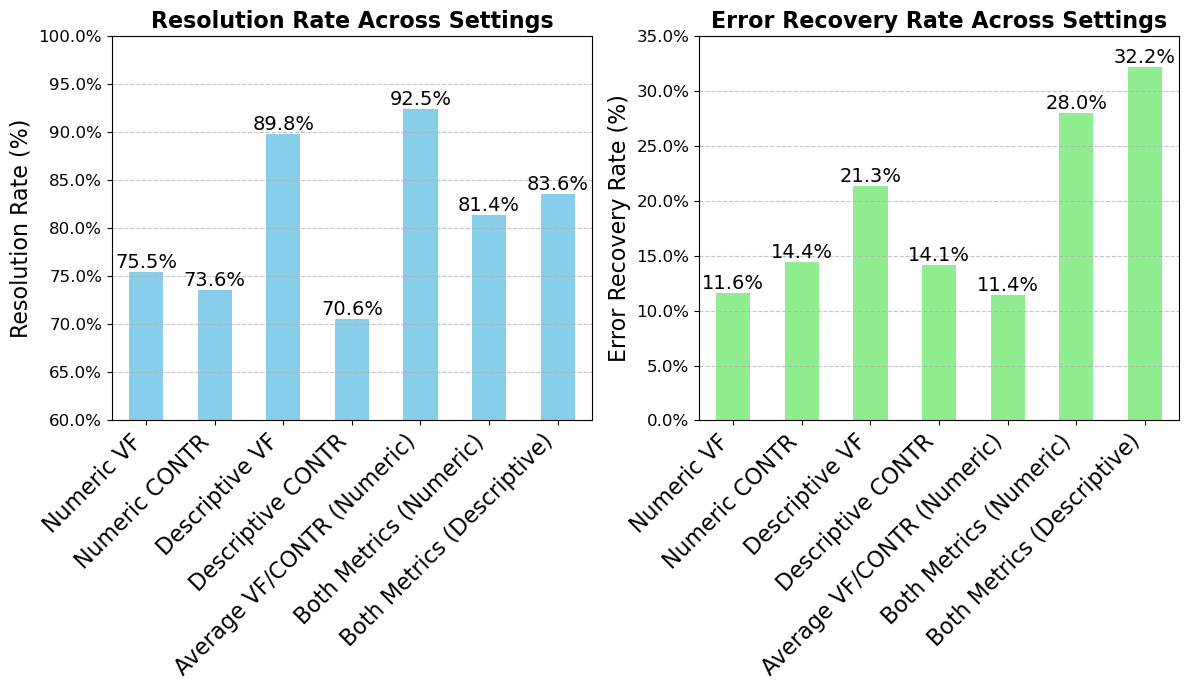

In [25]:
# ---------------------------
# Updated Bar Plot for Resolution Rate and Error Recovery Rate (Separate Plots)
# with Larger Text, Renamed x‑Tick Labels, and Specified Y‑Range for Resolution Rate Plot
# ---------------------------
if all_setting_scores:
    import matplotlib.ticker as mtick
    # Create a DataFrame from the scores and simplify the setting names.
    df_scores = pd.DataFrame(all_setting_scores)
    df_scores["SettingShort"] = df_scores["Setting"].apply(lambda s: s.split('_llava')[0])
    df_scores = df_scores.set_index("SettingShort")
    df_scores.index.name = None  # Remove the index label from the x-axis.
    
    # Define a mapping from the abbreviated setting names to more natural names.
    rename_mapping = {
        'vf_numeric': 'Numeric VF',
        'contr_numeric': 'Numeric CONTR',
        'showbothmetrics': 'Both Metrics (Numeric)',
        'avg_vf_contr_numeric': 'Average VF/CONTR (Numeric)',
        'showbothmetrics_descriptive': 'Both Metrics (Descriptive)',
        'vf_descriptive': 'Descriptive VF',
        'contr_descriptive': 'Descriptive CONTR'
    }
    
    # Extract the two metrics separately.
    resolution = df_scores["Resolution Rate"]
    error_recovery = df_scores["Error Recovery Rate"]
    
    # Set up subplots for each metric.
    fig, axes = plt.subplots(ncols=2, figsize=(12, 7))
    
    # Plot Resolution Rate.
    resolution.plot(kind="bar", ax=axes[0], color="skyblue")
    axes[0].set_title("Resolution Rate Across Settings", fontsize=16, fontweight="bold")
    axes[0].set_ylabel("Resolution Rate (%)", fontsize=16)
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)
    axes[0].set_xlabel("")  # Remove the x-axis label
    axes[0].tick_params(axis="both", labelsize=12)
    # Replace x tick labels using the mapping.
    new_labels = [rename_mapping.get(label.get_text(), label.get_text()) 
                  for label in axes[0].get_xticklabels()]
    axes[0].set_xticklabels(new_labels, rotation=45, ha="right", fontsize=16)
    axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # Set custom y-axis range
    axes[0].set_ylim(0.6, 1)
    # Annotate each bar (multiplying value by 100 for percentage display).
    for rect in axes[0].patches:
        height = rect.get_height()
        axes[0].text(rect.get_x() + rect.get_width()/2, height, f"{height*100:.1f}%",
                     ha="center", va="bottom", fontsize=14)
    
    # Plot Error Recovery Rate.
    error_recovery.plot(kind="bar", ax=axes[1], color="lightgreen")
    axes[1].set_title("Error Recovery Rate Across Settings", fontsize=16, fontweight="bold")
    axes[1].set_ylabel("Error Recovery Rate (%)", fontsize=16)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)
    axes[1].set_xlabel("")  # Remove the x-axis label
    axes[1].tick_params(axis="both", labelsize=12)
    new_labels = [rename_mapping.get(label.get_text(), label.get_text()) 
                  for label in axes[1].get_xticklabels()]
    axes[1].set_xticklabels(new_labels, rotation=45, ha="right", fontsize=16)
    axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[1].set_ylim(0, 0.35)
    for rect in axes[1].patches:
        height = rect.get_height()
        axes[1].text(rect.get_x() + rect.get_width()/2, height, f"{height*100:.1f}%",
                     ha="center", va="bottom", fontsize=14)
    
    plt.tight_layout()
    plt.show()
